In [1]:
import torch
import pickle, copy, json

from torch.nn import CrossEntropyLoss, MSELoss, KLDivLoss
import importlib
from model.MedClinical import Biobert_fc, Biobert_crf


from tqdm.notebook import tqdm, trange
import os
from transformers import BertTokenizer, BertModel
# from transformers import  BertForMaskedLM, BertForSequenceClassification, BertForTokenClassification
from pytorch_pretrained_bert import  BertForMaskedLM, BertForSequenceClassification, BertForTokenClassification
from transformers.optimization import AdamW
from torch.optim import lr_scheduler
import torch.optim as optim
from transformers import get_linear_schedule_with_warmup
from util.tools  import *
from util.DataLoader import MultiClassificationProcessor



In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

### Reading configuration

In [3]:
from types import SimpleNamespace
config_folder = "config/"

class obj(object):
    def __init__(self, d):
        for a, b in d.items():
            if isinstance(b, (list, tuple)):
               setattr(self, a, [obj(x) if isinstance(x, dict) else x for x in b])
            else:
               setattr(self, a, obj(b) if isinstance(b, dict) else b)

with open(os.path.join(config_folder, "config.json")) as f:
    config = obj(json.load(f))

# config.hyperparams.optimizer, config.programsettings.DATA_DIR

### Load the data for training

In [4]:
dataprocessor = MultiClassificationProcessor()
train_dataloader, data_len, num_labels, num_train_optimization_steps, all_label_ids = dataprocessor.get_data_loader(config,source='train')

INFO:root:***** Running training *****
INFO:root:  Num examples = 99
INFO:root:  Batch size = 24
INFO:root:  Num steps = 40


In [5]:
# if config.programsettings.MODEL_NAME == "BioBERT_fc":
#     model = Biobert_fc()
# elif config.programsettings.MODEL_NAME == "BERT_Sequence":
#     model = BertForSequenceClassification.from_pretrained(config.programsettings.BERT_MODEL, cache_dir=config.programsettings.CACHE_DIR, num_labels=num_labels)
model = Biobert_crf(device)


#### Freezing pretrained Transformer Layers

In [6]:
if config.hyperparams.NUM_BERT_LAYERS_FREEZE >= 0:
    count = 0 
    for child in model.children():
        count+=1
        if count < config.hyperparams.NUM_BERT_LAYERS_FREEZE:
            for param in child.parameters():
                param.requires_grad = False

In [7]:
optimizer     = optim.AdamW(model.parameters(), lr=config.hyperparams.LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=config.hyperparams.NUM_WARMP_STEPS, num_training_steps =num_train_optimization_steps)  # PyTorch scheduler

In [8]:
# from train import train_model
from train import *
model = train_model(config, model,  optimizer, scheduler, train_dataloader, num_labels, data_len,
                    device = device, model_save_path = config.programsettings.OUTPUT_DIR, 
                    model_name = config.programsettings.MODEL_NAME , num_epochs=config.hyperparams.NUM_TRAIN_EPOCHS)

Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Epoch:   0%|                                                                                    | 0/10 [00:02<?, ?it/s]

torch.Size([24, 128, 9])



RuntimeError: shape '[-1, 9]' is invalid for input of size 3072

## Now, let us evaluate on Training Set

In [9]:
# model = Biobert_fc()
# # model =  BertModel.from_pretrained((BERT_MODEL))
# path = OUTPUT_DIR +  'pytorch_model.bin'
# model.load_state_dict(torch.load(path))
# x = model.to(device)
# model.eval()

In [10]:
from eval import eval_model
preds, loss = eval_model( model, train_dataloader, device, num_labels)


In [11]:
len(preds), len(all_label_ids)

(100, 100)

In [12]:
import json
CONFIG_FOLDER = 'config/'
id_label_file = 'id_2_label.json'
with open(CONFIG_FOLDER + id_label_file) as infile:
    id2label = json.load(infile)

In [13]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix

preds_labels = [id2label[str(p)] for p in preds]
all_labels =  [id2label[str(l)] for l in all_label_ids.numpy()]
mcc = matthews_corrcoef(all_labels, preds_labels)

print('Correlation Coefficient is ', mcc)

mismatches = []
all_rels = []
for row in range(len(all_labels)):
    all_rels.append([all_labels[row], preds_labels[row]])
    if preds_labels[row] != all_labels[row]:
        mismatches.append([all_labels[row], preds_labels[row]])
        

Correlation Coefficient is  0.004053733667408329


INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


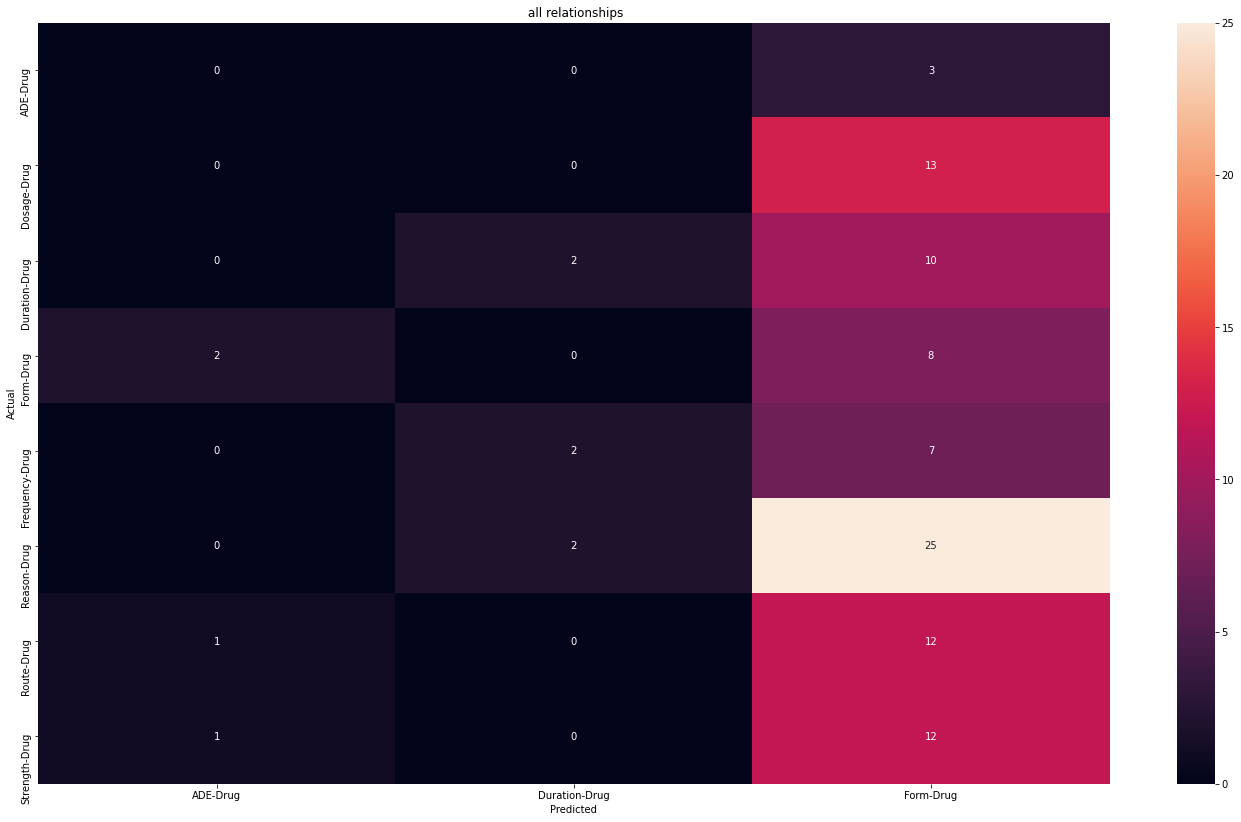

In [14]:
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

df = pd.DataFrame(all_rels, columns = ['labels', 'predicted'])
# df.head(10)
plt.figure(figsize=(24,14))
plt.title(" all relationships")
confusion_matrix = pd.crosstab(df['labels'], df['predicted'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)

plt.show()


In [15]:
# confusion_matrix.to_csv('test')

In [16]:
from sklearn import metrics
metrics.f1_score(df["labels"], df["predicted"], average='micro')

0.10000000000000002

In [42]:
df["matched"] = df["labels"] == df["predicted"]
df.groupby(["labels", "matched"]).count()

,,predicted
labels,matched,
ADE-Drug,False,8
Duration-Drug,False,1
Form-Drug,True,2
Frequency-Drug,False,7
Reason-Drug,False,5
Route-Drug,False,5
Strength-Drug,False,1
no relation,False,71


### Let us run into Eval set

In [22]:
dev_dataloader, dev_data_len, dev_num_labels, dev_num_train_optimization_steps, all_dev_label_ids = dataprocessor.get_data_loader(config,source='dev')

INFO:root:***** Running training *****
INFO:root:  Num examples = 100
INFO:root:  Batch size = 12
INFO:root:  Num steps = 8


In [23]:
preds_dev, loss_dev = eval_model( model, train_dataloader, device, num_labels)

In [24]:
loss_dev

2.305872572792901

In [25]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix

preds_labels = [id2label[str(p)] for p in preds_dev]
all_labels =  [id2label[str(l)] for l in all_dev_label_ids.numpy()]
mcc = matthews_corrcoef(all_labels, preds_labels)

print('Correlation Coefficient is ', mcc)

mismatches = []
all_rels = []
for row in range(len(all_labels)):
    all_rels.append([all_labels[row], preds_labels[row]])
    if preds_labels[row] != all_labels[row]:
        mismatches.append([all_labels[row], preds_labels[row]])
        

Correlation Coefficient is  -0.006049977575911709


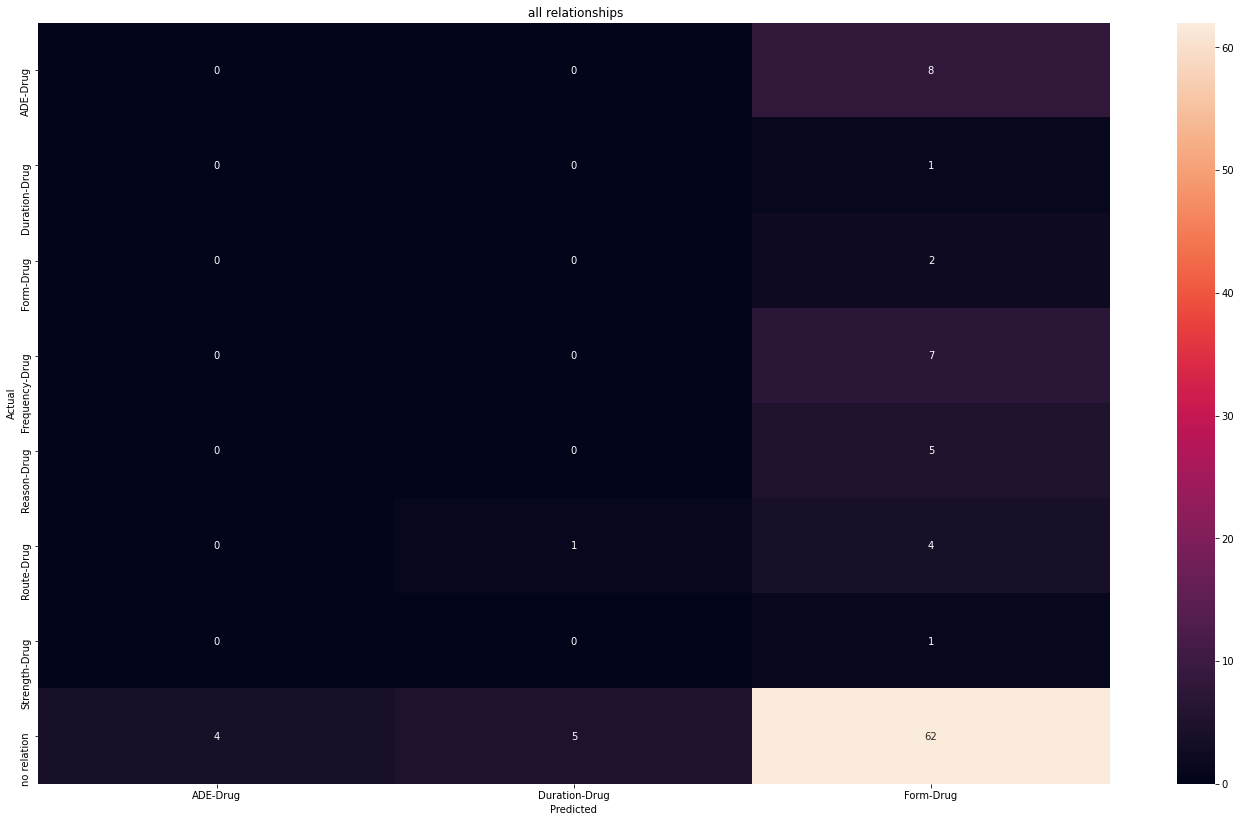

In [26]:
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

df = pd.DataFrame(all_rels, columns = ['labels', 'predicted'])
# df.head(10)
plt.figure(figsize=(24,14))
plt.title(" all relationships")
confusion_matrix = pd.crosstab(df['labels'], df['predicted'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)

plt.show()

In [27]:
from sklearn import metrics
metrics.f1_score(df["labels"], df["predicted"], average='micro')

0.02

In [43]:
df["matched"] = df["labels"] == df["predicted"]
df.groupby(["labels", "matched"]).count()

,,predicted
labels,matched,
ADE-Drug,False,8
Duration-Drug,False,1
Form-Drug,True,2
Frequency-Drug,False,7
Reason-Drug,False,5
Route-Drug,False,5
Strength-Drug,False,1
no relation,False,71
